<a href="https://colab.research.google.com/github/CHENHUI-X/Visualization_feature_map/blob/main/Visualization_feature_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How can we know that the feature extraction layer extracts the expected feature?** 

In [ ]:
from  torchsummary import summary
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:

summary(model,(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]          23,296
              ReLU-2           [-1, 64, 60, 60]               0
         MaxPool2d-3           [-1, 64, 29, 29]               0
            Conv2d-4          [-1, 192, 29, 29]         307,392
              ReLU-5          [-1, 192, 29, 29]               0
         MaxPool2d-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
             ReLU-12          [-1, 256, 14, 14]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
import requests
from PIL import Image
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
res = requests.get(url=url).content
with open(filename,'bw') as f:
  f.write(res)


In [ ]:
input_image = Image.open(filename)
input_image.show()

In [ ]:
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

model.eval()
#print(model)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# print(output)
print(np.shape(output))

torch.Size([1, 1000])


**How do get the output from an arbitrary layer of the model?**

Is there any elegant way for our needs in Pytorch? Yes, by using a hook. The way it works is by registering the layer we want using `register_forward_hook()` to a function that has an access to the model, input, and output from the layer.

In [ ]:

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
#register hook
model_children = list(model.children())
model_children[0][0].register_forward_hook(get_activation('cnn_0')) # register the output

In [ ]:
print(len(model_children))
for layer in model_children : print(layer)

3
Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
AdaptiveAvgPool2d(output_size=(6, 6))
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_fea

**To get the hook() function to work, you must run the model. Here is the code to get the image output from first CL.**

In [ ]:
with torch.no_grad():
    output = model(input_batch)
print(np.shape(activation['cnn_0']))

torch.Size([1, 64, 55, 55])


In [ ]:
!mkdir feature_map

In [ ]:
dimensi_iter = activation['cnn_0'][0,:,:,:].size(dim=0)
for i in range(dimensi_iter):
    print('processing layer %s'%(i+1))
    im2 = plt.imshow(activation['cnn_0'][0,i,:,:].cpu().numpy(), cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')
    plt.colorbar()
    plt.savefig('feature_map/cnn_0_%s.png'%(i))
    plt.close()

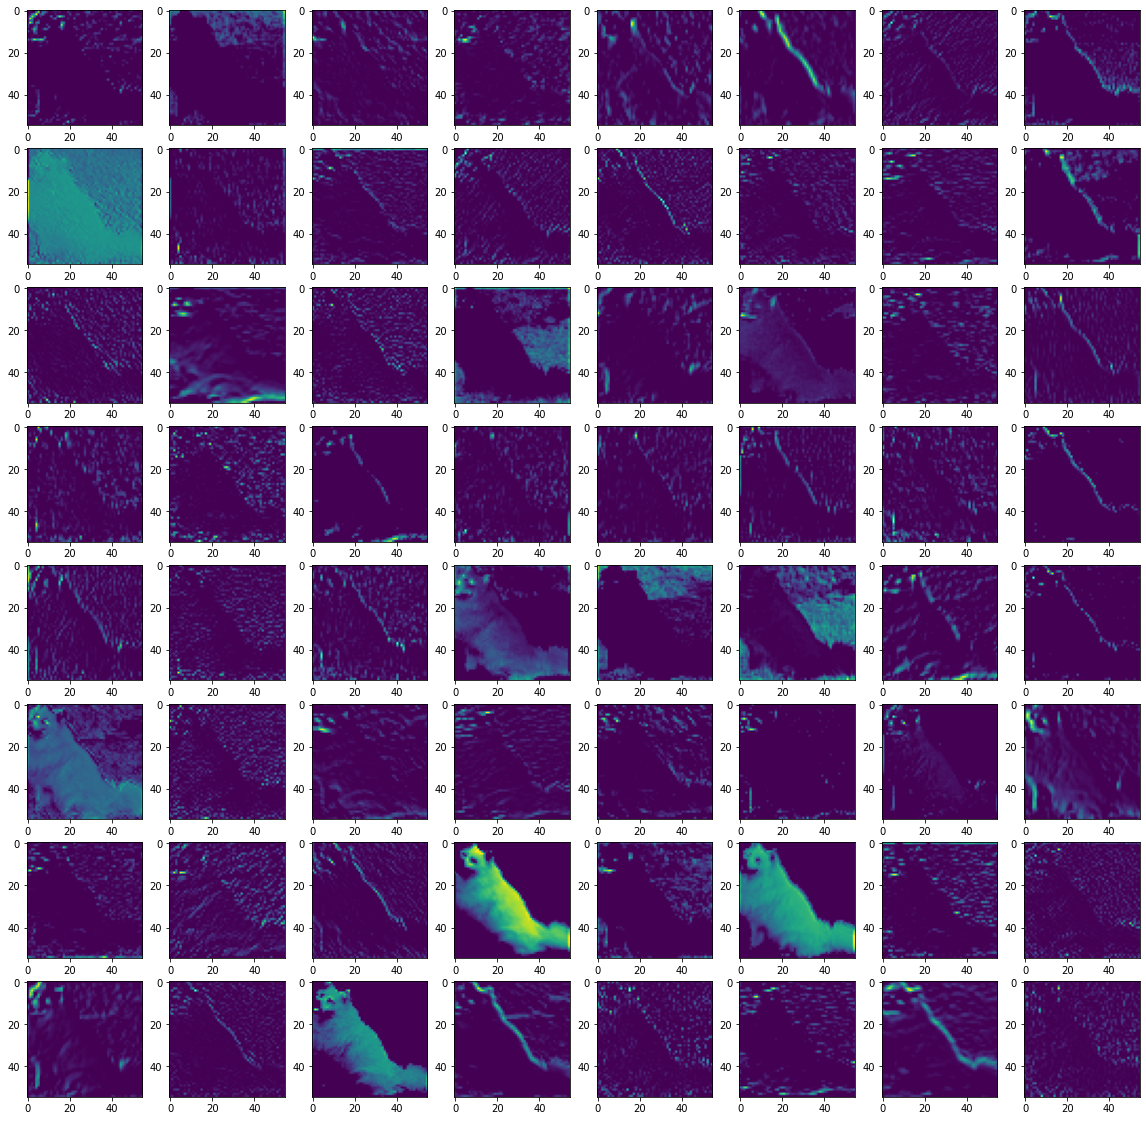

In [ ]:
from torchvision.utils import make_grid
import torchvision
# grid = make_grid([activation['cnn_0'][0,i,:,:].cpu() for i in range(64)], nrow = 8)
# img = torchvision.transforms.ToPILImage()(grid)
# img.show()
fig , ax = plt.subplots(nrows=8,ncols=8,figsize=[20,20])

for i in range(8):
  for j in range(8):
    ax[i,j].imshow(activation['cnn_0'][0,i*8+j,:,:].cpu())